
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./DiffusionSorptionDecay.ipynb" download="DiffusionSorptionDecay.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=DiffusionSorptionDecay.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/bilke/ogs/-/blob/web-versioning/Tests/Data/Parabolic/ComponentTransport/DiffusionSorptionDecay/DiffusionSorptionDecay.py"><img src="https://img.shields.io/static/v1?label=Source:&message=DiffusionSorptionDecay.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/Parabolic/ComponentTransport/DiffusionSorptionDecay/DiffusionSorptionDecay.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

# Diffusion-sorption-decay problem

## Problem description

This benchmark is meant to model radionuclide migration through a semi-infinite column of undisturbed Opalinus Clay (OPA), which could potentially serve as a geological repository for radioactive waste. In this benchmark, Cesium ($^{135}$Cs) is chosen for investigation because it may be present in the repository if the disposal canister is ruptured. In view of the low hydraulic conductivity of OPA, Cesium migration is considered to be dominated by diffusion. Two additional processes are also considered, including (i) retardation resulting from solute sorption on the clay, and (ii) concentration attenuation caused by radioactive decay over time.

In the one-dimensional model setup, the mass balance equation for the diffusion-sorption-decay process is given as follows:

$$
\frac{\partial \left( \phi R c\right)}{\partial t} = \frac{\partial}{\partial x} \left(\phi \mathrm{D_p} \frac{\partial c}{\partial x} \right) - \phi \alpha R c,
$$

where $c$ [mol/m$^3$] represents the $^{135}$Cs concentration in this example, $\mathrm{D_p}$ [m$^2$/s] is the pore diffusion coefficient for $^{135}$Cs, $\phi$ [-] is the porosity of OPA, $R$ [-] is the retardation factor defined as

$$
R = 1 + \rho k_{d} / \phi,
$$

with the dry density of OPA $\rho$ [kg/m$^3$] and the distribution coefficient $k_d$ [m$^3$/kg], and $\alpha$ [1/s] is the first-order decay constant, i.e.:

$$
\alpha = \mathrm{ln} 2 \, / \, t_{1/2},
$$

where $t_{1/2}$ [s] is the half life of the diffusing radionuclide.

## Model setups

Our simulation domain is set to be 20 meters long, which is sufficient to ensure that the concentration profile does not reach the right-hand boundary during simulation. The simulated time is one million years. Initially, the entire domain is assumed to be solute free, i.e., $c_{\mathrm{ini}}(x, 0) = 0$. The inlet concentration is held at 1 mol/L throughout the simulation, i.e., $c(0, t) = 1$ mol/L. The spatial domain is discretized by linear line elements with a length of 0.01 meter each. The time step size of one thousand years is used in the simulation. The linearized governing equation is iteratively solved using the Newton-Raphson method.

The table below summarizes the parameters used in the simulation.

|                 Parameter                 |  Value   |   Unit   |
| :---------------------------------------: | :------: | :------: |
|              Porosity $\phi$              |   0.12   |    -     |
| Pore diffusion coefficient $\mathrm{D_p}$ | 8.33e-11 | m$^2$/s  |
|          OPA bulk density $\rho$          |   2394   | kg/m$^3$ |
|     Distribution coefficient $k_{d}$      |   0.5    | m$^3$/kg |
|      $^{135}$Cs half life $t_{1/2}$       |  2.3e6   |   year   |
|         Time step size $\Delta t$         |   1e3    |   year   |
|           Grid size $\Delta x$            |   0.01   |    m     |

Notes: The parameter values are sourced from Nagra (2002).

## Results

**Analytical solution**

The time-dependent concentration profile can be analytically calculated as a function of $t$ and $x$. The analytical solution for this diffusion-soprtion-decay system is given in Carslaw and Jaeger (1959):

$$
c(x, t) = \frac{c_0}{2} \left\{ \mathrm{exp} \left[-x \left(\frac{\alpha R}{\mathrm{D_p}}\right)^{\frac{1}{2}} \right] \mathrm{erfc} \left[ \frac{x}{2} \left(\frac{R}{\mathrm{D_p}t}\right)^{\frac{1}{2}} - \left(\alpha t\right)^{\frac{1}{2}}\right] + \mathrm{exp} \left[x \left(\frac{\alpha R}{\mathrm{D_p}}\right)^{\frac{1}{2}} \right] \mathrm{erfc} \left[ \frac{x}{2} \left(\frac{R}{\mathrm{D_p}t}\right)^{\frac{1}{2}} + \left(\alpha t\right)^{\frac{1}{2}}\right]\right\}
$$

Below a python script is presented, through which the concentration profiles can be analytically calculated at any time.

Here the concentration profiles are illustrated at $t$ = 10$^3$, 10$^4$, 10$^5$, and 10$^6$ years.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
from scipy.special import erfc

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)


def plot_results_and_errors(ms: ot.MeshSeries, analytical_func):
    "Plot numerical results against analytical solution"
    var = ot.variables.Scalar("Cs", "mol/L", "mol/L", "Cs concentration")
    ref_vals = analytical_func(ms[0].points[:, 0], ms.timevalues)
    labels = [f"{tv / 86400 / 365.25:.0e} a" for tv in ms.timevalues]
    abs_err = ms["Cs"] - ref_vals
    max_errors = [2e-1, 2e-2, 2e-3, 5e-4]  # per timevalue
    assert np.all(np.abs(abs_err.T) <= max_errors)

    fig_res_err, axs = plt.subplots(1, 2, figsize=(11, 4))
    axs: list[plt.Axes]

    ms.point_data[var.anasol.data_name] = ref_vals
    ms.point_data[var.abs_error.data_name] = abs_err
    ot.plot.line(ms, var, ax=axs[0], marker="o", labels=labels)
    ot.plot.line(ms, var.anasol, ax=axs[0], ls="--")
    ot.plot.line(ms, var.abs_error, ax=axs[1])
    axs[0].plot([], [], "-ok", ms=3, label="OGS-numerical")
    axs[0].plot([], [], "--k", label="analytical")
    axs[0].legend(fontsize=10)
    axs[1].set_yscale("symlog", linthresh=0.001)
    for ax_i in [axs[0], axs[1]]:
        ax_i.set_xscale("log")
    ot.plot.utils.update_font_sizes(axs, 10)
    fig_res_err.tight_layout()

In [2]:
###Model parameters###
De = 1e-11  #    Effective diffusion coefficient [m2/s]
phi = 0.12  #    Porosity [-]
Dp = De / phi  # Pore diffusion coefficient [m2/s]
rho = 2.394e3  # Porous medium bulk density [kg/m3]
Kd = 0.5  #      Distribution coefficient [m3/kg]
half_life = 2.3e6  # 135-Cs Half-life [year]
alpha = np.log(2) / half_life / 3.1536e7  # Decay constant [1/s]

###Initial condition and boundary conditions###
c_ini = 0  #     Initial condition [mol/L]
c_inlet = 1  #   Inlet concentration [mol/L]

###Intermediate parameters###
R = 1 + rho * Kd / phi  # Retardation factor [-]


def c_diff_sorp_dec(x_arr: np.ndarray, t_arr: np.ndarray) -> np.ndarray:
    def H(x_arr: np.ndarray, t_arr: np.ndarray, sign: float):
        x_, t_ = (x_arr[:, None], t_arr[None, :])
        return np.exp(sign * x_ * (alpha * R / Dp) ** 0.5) * erfc(
            0.5 * x_ @ (R / Dp / t_) ** 0.5 + sign * (alpha * t_) ** 0.5
        )

    return 0.5 * c_inlet * (H(x_arr, t_arr, 1) + H(x_arr, t_arr, -1)).T

**Numerical solution**

Correspondingly, the OGS input files of this 1D mass transport model can be found <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ComponentTransport/DiffusionSorptionDecay/DiffusionSorptionDecay.prj">here</a>.

Then, the numerical solution of OpenGeoSys is plotted against the analytical solution for comparison.

In [3]:
# Run OGS simulation
name = "1D_DiffusionSorptionDecay"
model = ot.Project(
    input_file=f"{name}.prj", output_file=out_dir / f"{name}_modified.prj"
)
model.write_input()
model.run_model(logfile=out_dir / "out.txt", args=f"-o {out_dir} -m .")

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Parabolic/ComponentTransport/DiffusionSorptionDecay/DiffusionSorptionDecay/1D_DiffusionSorptionDecay_modified.prj
Status: finished successfully.
Execution took 1.1953377723693848 s


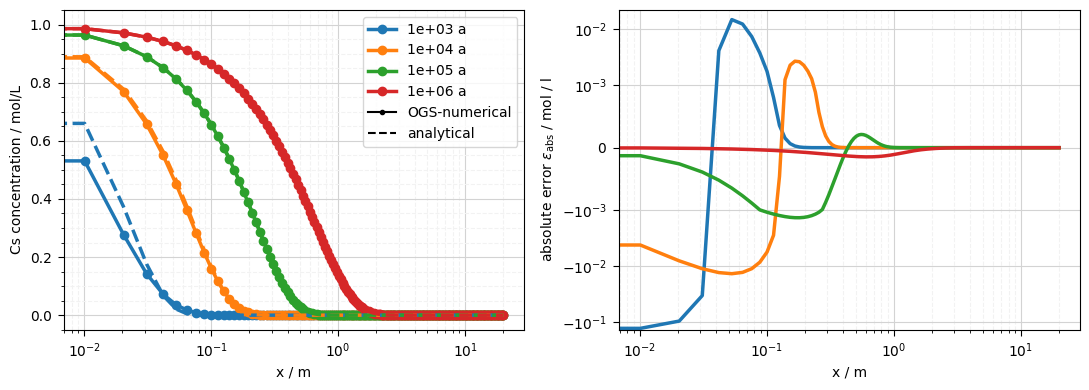

In [4]:
ms_DSD = ot.MeshSeries(out_dir / f"{name}.pvd")[1:]
plot_results_and_errors(ms_DSD, c_diff_sorp_dec)

In the figure above, it can be seen that the numerical profiles and analytical solutions agree well at different times.

**Error estimation**

To evaluate the accuracy of numerical solution, the Euclidean norm of the approximate solution error $|| \mathbf{c} - \mathbf{c}^{\mathrm{exact}}||_{2} = \left(\sum\mathop{}_{\mkern-5mu i} |c_i - c_{i}^{\mathrm{exact}}|^2 \right)^{1/2}$ over the entire domain is calculated based on the exact analytical solution $\mathbf{c}^{\mathrm{exact}}$.

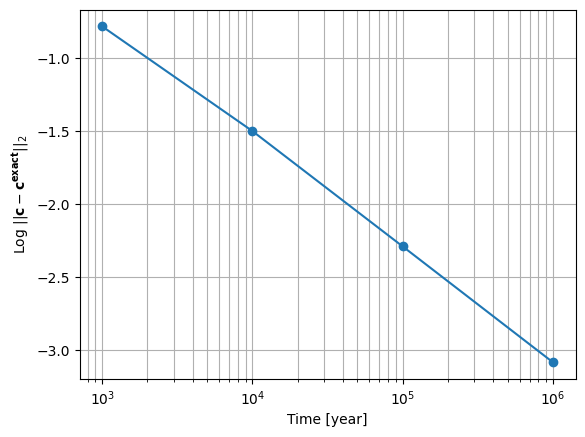

In [5]:
c_sim = ms_DSD.values("Cs")
c_ref = c_diff_sorp_dec(ms_DSD[0].points[:, 0], ms_DSD.timevalues)
l2_norm_error = np.log10(np.sum((c_sim - c_ref) ** 2, axis=-1) ** 0.5)
np.testing.assert_array_less(l2_norm_error, -0.5)

fig, ax = plt.subplots()
ax.set_xlabel("Time [year]")
ax.set_ylabel(r"Log $||\mathbf{c}-\mathbf{c^{exact}}||_{2}$")
ax.semilogx(ms_DSD.timevalues / 86400 / 365.25, l2_norm_error, "-o", lw=1.5)
ax.grid(True, "both")

As the simulation time increases, the L$_2$ error norm decreases rapidly and evenually drops down to 10$^{-3}$.

# Advection-diffusion-sorption-decay problem

## Problem description

From the preceding example, we further incorporate advective transport within OPA. The mass balance equation is thus extended into

$$
\frac{\partial \left( \phi R c\right)}{\partial t} = \frac{\partial}{\partial x} \left(\phi \mathrm{D_p} \frac{\partial c}{\partial x} - qc \right) - \phi \alpha R c,
$$

with the Darcy velocity $q$ [m/s]. Note that the effect of velocity-dependent dispersion is neglected.

## Model setups

The parameters used in this example are kept the same as in the preceding one (see the table below), except we addtionally consider a constant Darcy velocity of 2e-11 m/s through OPA.

|                 Parameter                 |  Value   |   Unit   |
| :---------------------------------------: | :------: | :------: |
|              Porosity $\phi$              |   0.12   |    -     |
| Pore diffusion coefficient $\mathrm{D_p}$ | 8.33e-11 | m$^2$/s  |
|          OPA bulk density $\rho$          |   2394   | kg/m$^3$ |
| Distribution coefficient $k_{\mathrm{d}}$ |   0.5    | m$^3$/kg |
|      $^{135}$Cs half life $t_{1/2}$       |  2.3e6   |   year   |
|            Darcy velocity $q$             |  2e-11   |   m/s    |
|         Time step size $\Delta t$         |   1e3    |   year   |
|           Grid size $\Delta x$            |   0.01   |    m     |

## Results

**Analytical solution**

Likewise, we find the analytical solution for this advection-diffusion-soprtion-decay system in Van Genuchten (1981), which is given as:

$$
c(x,t) = c_0 H(x,t) + M(x,t),
$$

where

$$
H(x,t) = \frac{1}{2}\mathrm{exp}\left[\frac{\left(v-u\right)x} {2D_{\mathrm{p}}}\right]\mathrm{erfc}\left[\frac{Rx-ut}{2\left(D_{\mathrm{p}}Rt\right)^{1/2}}\right] + \frac{1}{2}\mathrm{exp}\left[\frac{\left(v+u\right)x} {2D_{\mathrm{p}}}\right]\mathrm{erfc}\left[\frac{Rx+ut}{2\left(D_{\mathrm{p}}Rt\right)^{1/2}}\right],
$$

$$
M(x,t) = -c_{\mathrm{ini}} \mathrm{exp}\left(-\frac{\mu t}{R}\right)\left\{\frac{1}{2}\mathrm{erfc}\left[\frac{Rx-vt}{2\left(D_{\mathrm{p}}Rt\right)^{1/2}}\right] + \frac{1}{2}\mathrm{exp}\left(\frac{vx}{D_{\mathrm{p}}}\right)\mathrm{erfc}\left[\frac{Rx+vt}{2\left(D_{\mathrm{p}}Rt\right)^{1/2}}\right]\right\} + c_i \mathrm{exp}\left(-\frac{\mu t}{R}\right),
$$

and

$$
u = v \left(1 + \frac{4\mu D_{\mathrm{p}}}{v^2} \right)^{1/2},
$$

with the pore water velocity $v$ [m/s], i.e., $v = q \,/ \phi$, and $\mu = \alpha R$.

In [6]:
###Input parameters###
De = 1e-11  #    Effective diffusion coefficient [m2/s]
phi = 0.12  #    Porosity [-]
D = De / phi  #  Pore diffusion coefficient [m2/s]
rho = 2.394e3  # Porous medium bulk density [kg/m3]
Kd = 0.5  #      Distribution coefficient [m3/kg]
R = 1 + rho * Kd / phi  #   Retardation factor [-]
half_life = 2.3e6  #        135-Cs Half-life [year]
k = np.log(2) / half_life / 3.1536e7  # Decay constant [1/s]
# Include advective mechansim
q = 2e-11  #    Darcy velocity [m/s]
v = q / phi  #  Pore water velocity [m/s]

###Initial condition and boundary conditions###
c_ini = 0  #    Initial condition [mol/L]
c0 = 1  #       Inflow concentration [mol/L]

###Intermediate parameters###
mu = k * R
u = v * (1 + 4 * mu * D / v**2) ** 0.5


def c_adv_diff_sorp_dec(x_arr: np.ndarray, t_arr: np.ndarray) -> np.ndarray:
    "Analytical solution"

    def H(x_arr: np.ndarray, t_arr: np.ndarray):
        x, t = (x_arr[:, None], t_arr[None, :])
        return 0.5 * np.exp((v - u) * x / 2 / D) * erfc(
            (R * x - u * t) / 2 / (D * R * t) ** 0.5
        ) + 0.5 * np.exp((v + u) * x / 2 / D) * erfc(
            (R * x + u * t) / 2 / (D * R * t) ** 0.5
        )

    def M(x_arr: np.ndarray, t_arr: np.ndarray):
        x, t = (x_arr[:, None], t_arr[None, :])
        return -c_ini * np.exp(-mu * t / R) * (
            0.5 * erfc((R * x - v * t) / 2 / (D * R * t) ** 0.5)
            + 0.5 * np.exp(v * x / D) * erfc((R * x + v * t) / 2 / (D * R * t) ** 0.5)
        ) + c_ini * np.exp(-mu * t / R)

    return c0 * (H(x_arr, t_arr) + M(x_arr, t_arr)).T

**Numerical solution**

Also, a 1D mass transport model is established. The corresponding OGS input files can be found <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ComponentTransport/AdvectionDiffusionSorptionDecay/1D_AdvectionDiffusionSorptionDecay.prj">here</a>.

Then, the numerical solution is plotted against the analytical solution for comparison.

In [7]:
# Run OGS simulation
name = "AdvectionDiffusionSorptionDecay"
model = ot.Project(
    input_file=f"../{name}/1D_{name}.prj", output_file=out_dir / f"{name}_modified.prj"
)
model.write_input()
model.run_model(logfile=out_dir / "out.txt", args=f"-o {out_dir} -m ../{name}/")

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Parabolic/ComponentTransport/DiffusionSorptionDecay/DiffusionSorptionDecay/AdvectionDiffusionSorptionDecay_modified.prj
Status: finished successfully.
Execution took 8.791585445404053 s


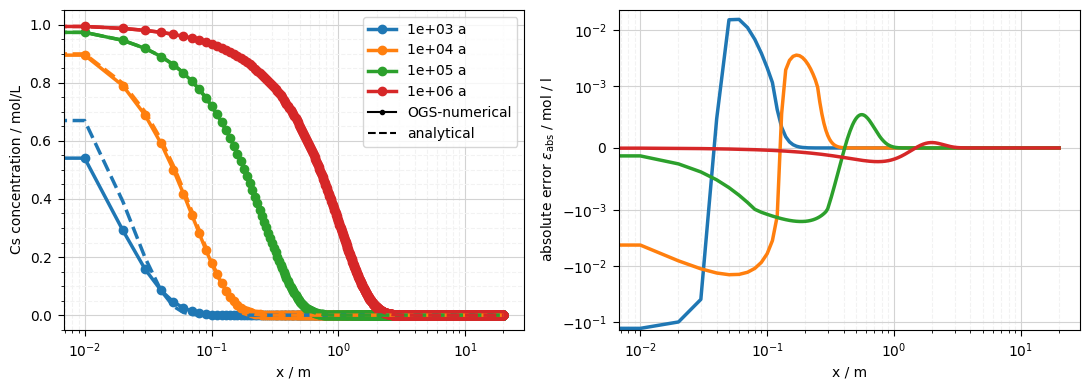

In [8]:
ms_ADSD = ot.MeshSeries(out_dir / f"1D_{name}.pvd")[1:]
plot_results_and_errors(ms_ADSD, c_adv_diff_sorp_dec)

As shown in the figure above, the numerical and analytical solutions at different times reach in a good agreement.

## References

<a href="https://nagra.ch/downloads/technical-report-ntb-02-06/">Nagra, 2002.</a> Project Opalinus Clay: Models, Codes and Data for Safety Assessment. Technical Report NTB 02–06. Nagra, Switzerland.

Carslaw, H. S. & Jaeger, J. C., 1959: Conduction of heat in solids. 2nd Ed., Oxford Science Publications, Clarendon
Press, Oxford, UK.

Van Genuchten, M.T., 1981. Analytical solutions for chemical transport with simultaneous adsorption, zero-order production and first-order decay. Journal of hydrology, 49(3-4), pp.213-233.

**Credits:**

Renchao Lu, Jaime Garibay-Rodriguez, Lars Bilke, Christoph Lehmann, Haibing Shao